In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.datasets import MNIST, FashionMNIST
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt

### Utils

In [ ]:
def to_binary(x, threshold):
  return torch.where(
      x > threshold, torch.tensor(1, dtype=x.dtype), torch.tensor(0, dtype=x.dtype))

def create_negative_data(x):
  n = x.shape[0]

  mask = np.random.randint(2, size=(n, 28, 28))
  mask = mask.astype(np.float32)

  print('Creating negative data . . .')

  for i in tqdm(range(n)):
    for _ in range(30):
      mask[i] = cv2.filter2D(
          mask[i], -1, kernel=np.array([[1/4, 1/2, 1/4]])
      )
      mask[i] = cv2.filter2D(
          mask[i], -1, kernel=np.array([[1/4], [1/2], [1/4]])
      )

  mask = cv2.threshold(mask, 0.5, 1, cv2.THRESH_BINARY)[1]

  x_neg = x[torch.randperm(n)] * mask + x[torch.randperm(n)] * (1 - mask)

  return x_neg.type(torch.uint8)


class FFDataset(Dataset):
    def __init__(self, h_pos):
        self.h_pos = h_pos

    def __len__(self):
        return self.h_pos.shape[0]

    def __getitem__(self, idx):
        return self.h_pos[idx]

class SimpleDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]


def display(x_recon):
  '''
    x_recon: (N, 1, 28, 28)
  '''

  x_recon = x_recon.cpu().detach()

  idxs = np.random.choice(x_recon.shape[0], 100, replace=False)

  samples = x_recon[idxs].squeeze().permute(1, 2, 0).numpy()
  samples = samples.reshape(28, 28, 10, 10).transpose(2,0,3,1).reshape(28*10,-1)

  plt.figure(figsize = (8,8))
  plt.axis('off')
  plt.imshow(samples, cmap='gray')

### FF

In [ ]:
class FFLayer(nn.Module):
    def __init__(self, in_dims, out_dims, dropout):
        super().__init__()

        self.linear = nn.Linear(in_dims, out_dims)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        output = F.relu(self.dropout(self.linear(x)))
        normalized = self.normalize(output)
        return output, normalized

    def normalize(self, x):
        return x / (x.norm(p=2, dim=1, keepdim=True) + 1e-7)


class FFNN:
    def __init__(self, dims, threshold, lr, batch_size, epochs, dropout, device):
        self.epochs = epochs
        self.batch_size = batch_size
        self.threshold = threshold
        self.device = device

        self.fflayers = [FFLayer(dims[d], dims[d+1], dropout).to(device) for d in range(len(dims) - 1)]
        self.optimizers = [torch.optim.Adam(l.parameters(), lr=lr) for l in self.fflayers]

        self.linear = nn.Linear(sum(dims[2:]), dims[0]).to(device)
        self.optimizer = torch.optim.Adam(self.linear.parameters(), lr=lr)

        self.criterion = nn.BCEWithLogitsLoss()

        self.loss_history = []

    def train(self, x_pos):
      train_dataset = FFDataset(x_pos)
      train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)


      for epoch in range(self.epochs):
        print(f'\n[EPOCH {epoch+1}/{self.epochs}]\n')

        epoch_loss = [0 for _ in range(len(self.fflayers)+1)]
        bar = tqdm(train_loader)

        for x_pos_batch in bar:
          x_pos_batch = x_pos_batch.to(self.device)

          # ff-layers positive path
          normalized_outputs = []
          h_pos_batch = x_pos_batch
          for i, layer in enumerate(self.fflayers):
            output, normalized = layer(h_pos_batch)

            goodness = output.pow(2).sum(1)
            loss = self.criterion(goodness - self.threshold, torch.ones((goodness.shape[0]), device=goodness.device))

            self.optimizers[i].zero_grad()
            loss.backward()
            self.optimizers[i].step()

            h_pos_batch = normalized.detach()

            normalized_outputs.append(h_pos_batch)

            epoch_loss[i] += loss.item()

          # final layer for generating negative samples
          cat_outputs = torch.cat(normalized_outputs[1:], dim=1)
          x_neg_batch = self.linear(cat_outputs)

          loss = self.criterion(x_neg_batch, x_pos_batch)

          self.optimizer.zero_grad()
          loss.backward()
          self.optimizer.step()

          epoch_loss[-1] += loss.item()

          # ff-layers negative path
          h_neg_batch = to_binary(F.sigmoid(x_neg_batch), 0.5).detach()
          for i, layer in enumerate(self.fflayers):
            output, normalized = layer(h_neg_batch)

            goodness = output.pow(2).sum(1)
            loss = self.criterion(goodness - self.threshold, torch.zeros((goodness.shape[0]), device=goodness.device))

            self.optimizers[i].zero_grad()
            loss.backward()
            self.optimizers[i].step()

            h_neg_batch = normalized.detach()

            epoch_loss[i] += loss.item()

        for i in range(len(epoch_loss) - 1):
          epoch_loss[i] /= (len(train_loader)*2)
        epoch_loss[-1] /= len(train_loader)

        self.loss_history.append(epoch_loss)

        for i in range(len(epoch_loss)):
          print(f'Layer-{i}: {epoch_loss[i]:.5f}')

In [ ]:
import itertools

class LocalConv(nn.Module):
    def __init__(self,
                 out_channels,
                 input_shape,
                 kernel_size,
                 strides,
                 bias=False,
                ):
      super().__init__()

      self.out_channels = out_channels
      self.kernel_size = kernel_size
      self.strides = strides
      self.bias = bias

      input_row, input_col = input_shape[1:]
      input_filter = input_shape[0]

      output_row = self.output_length(input_row, self.kernel_size[0], self.strides[0])
      output_col = self.output_length(input_col, self.kernel_size[1], self.strides[1])

      self.output_shape = (output_row, output_col)

      self.kernel_shape = (output_row * output_col,
                           self.kernel_size[0] * self.kernel_size[1] * input_filter,
                           self.out_channels
                           )

      self.kernel = nn.Parameter(torch.randn(self.kernel_shape))

      if self.bias:
        self.bias_shape = (self.out_channels, output_row, output_col)
        self.bias = nn.Parameter(torch.randn(self.bias_shape))

    def output_length(self, input_length, kernel_size, stride):
      output_length = input_length - kernel_size + 1
      return (output_length + stride - 1) // stride

    def forward(self, inputs):
      feature_dim = self.kernel_shape[1]
      channels_out = self.kernel_shape[-1]

      xs = []
      output_axes_ticks = [range(axis_max) for axis_max in self.output_shape]
      for position in itertools.product(*output_axes_ticks):
        slices = [slice(None)]
        slices.append(slice(None))
        slices.extend(
            slice(
                position[d] * self.strides[d],
                position[d] * self.strides[d] + self.kernel_size[d],
            )
            for d in [0, 1]
        )
        xs.append(torch.reshape(inputs[slices], (1, -1, feature_dim)))

      x_aggregate = torch.cat(xs)

      output = torch.bmm(x_aggregate, self.kernel)
      output = torch.reshape(output, (self.output_shape + (-1, channels_out)))
      output =  torch.permute(output, (2, 3, 0, 1))

      if self.bias is not False:
        output = output + self.bias.unsqueeze(0)
      return output

class FFRFLayer(nn.Module):
    def __init__(self, out_channel, input_shape, kernel_size, strides, dropout):
        super().__init__()

        self.local_conv = LocalConv(out_channel, input_shape, kernel_size, strides, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        output = F.relu(self.dropout(self.local_conv(x)))
        normalized = self.normalize(output)
        return output, normalized

    def normalize(self, x):
        return x / (x.norm(p=2, dim=(1, 2, 3), keepdim=True) + 1e-7)

class FFRFNN:
    def __init__(self,
                 dropout,
                 threshold,
                 lr,
                 batch_size,
                 epochs,
                 momentum,
                 alpha,
                 device
                ):
        self.epochs = epochs
        self.batch_size = batch_size
        self.threshold = threshold
        self.device = device
        self.lr = lr

        self.fflayers = [
            FFRFLayer(32, (1,28,28), (7,7), (3, 3), dropout).to(device),
            FFRFLayer(256, (32, 8, 8), (4, 4), (2, 2), dropout).to(device),
            nn.Sequential(
                nn.Upsample(size=(8, 8), mode='bilinear'),
                FFRFLayer(32, (256, 8, 8), (1, 1), (1, 1), dropout)
            ).to(device)
        ]

        self.optimizers = [torch.optim.Adam(l.parameters(), lr=lr) for l in self.fflayers]

        self.decoder = nn.Sequential(
            nn.Upsample(size=(28, 28), mode='bilinear'),
            LocalConv(1, (64, 28, 28), (1,1), (1,1), bias=False)
        ).to(device)
        self.optimizer = torch.optim.Adam(self.decoder.parameters(), lr=lr)

        self.criterion = nn.BCEWithLogitsLoss()

        self.loss_history = []

        self.momentum = momentum
        self.alpha = alpha
        self.running_mean = torch.zeros((len(self.fflayers)), device=self.device, requires_grad=False)

    def peer_normalization(self, y, i):
      '''
        y: activity [N, C, H, W]
        i: layer idx
      '''
      avg_activities = y.mean(dim=(0,2,3))
      self.running_mean[i] = (1 - self.momentum) * self.running_mean[i] + self.momentum * avg_activities.mean().detach()
      return (avg_activities - self.running_mean[i]).pow(2).mean()

    def train(self, x_pos):
      dataset = FFDataset(x_pos)
      train_loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)

      for epoch in range(self.epochs):
        print(f'\n__ Epoch {epoch+1} __')

        epoch_loss = [0 for _ in range(len(self.fflayers)+1)]
        bar = tqdm(train_loader)

        for x_pos_batch in bar:
          x_pos_batch = x_pos_batch.to(self.device)

          # ff-layers positive path
          normalized_outputs = []
          h_pos_batch = x_pos_batch
          for i, layer in enumerate(self.fflayers):
            layer.train()

            output, normalized = layer(h_pos_batch)

            goodness = output.pow(2).sum(dim=(1,2,3))
            loss = self.criterion(goodness - self.threshold, torch.ones((goodness.shape[0]), device=goodness.device)) \
                   + self.alpha * self.peer_normalization(output, i)

            self.optimizers[i].zero_grad()
            loss.backward()
            self.optimizers[i].step()

            h_pos_batch = normalized.detach()

            normalized_outputs.append(h_pos_batch)

            epoch_loss[i] += loss.item()

          # final layer for generating negative samples
          self.decoder.train()

          cat_outputs = torch.cat([normalized_outputs[0], normalized_outputs[-1]], dim=1)
          x_neg_batch = self.decoder(cat_outputs)

          loss = self.criterion(x_neg_batch, x_pos_batch)

          self.optimizer.zero_grad()
          loss.backward()
          self.optimizer.step()

          epoch_loss[-1] += loss.item()

          # ff-layers negative path
          h_neg_batch = to_binary(F.sigmoid(x_neg_batch), 0.5).detach()
          for i, layer in enumerate(self.fflayers):
            layer.train()

            output, normalized = layer(h_neg_batch)

            goodness = output.pow(2).sum(dim=(1,2,3))
            loss = self.criterion(goodness - self.threshold, torch.zeros((goodness.shape[0]), device=goodness.device)) \
                   + self.alpha * self.peer_normalization(output, i)

            self.optimizers[i].zero_grad()
            loss.backward()
            self.optimizers[i].step()

            h_neg_batch = normalized.detach()

            epoch_loss[i] += loss.item()

        for i in range(len(epoch_loss) - 1):
          epoch_loss[i] /= (len(train_loader)*2)
        epoch_loss[-1] /= len(train_loader)

        self.loss_history.append(epoch_loss)

        for i in range(len(epoch_loss)):
          print(f'Layer-{i}: {epoch_loss[i]:.5f}')

    def reconstruct(self, dataloader):
      print('[Reconstruction]')
      bar = tqdm(dataloader)

      results = []

      with torch.no_grad():
        for x_batch in bar:
          x_batch = x_batch.to(self.device)
          cat = []
          for layer in self.fflayers:
            layer.eval()
            _, x_batch = layer(x_batch)
            cat.append(x_batch)

          cat_outputs = torch.cat([cat[0], cat[-1]], dim=1)
          self.decoder.eval()
          x_recon = self.decoder(cat_outputs)
          results.append(F.sigmoid(x_recon))

      x_recon_binary = to_binary(torch.cat(results, dim=0), 0.5)

      return x_recon_binary

    def train_classifier(self, x, labels):
      print(f'\n[Linear Layer]')

      # get features
      dataset = FFDataset(x)
      train_loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=False)

      ff_outputs = []

      bar = tqdm(train_loader)
      for x_pos_batch in bar:
        x_pos_batch = x_pos_batch.to(self.device)

        normalized_outputs = []
        h_pos_batch = x_pos_batch
        for i, layer in enumerate(self.fflayers):
          layer.eval()

          _, normalized = layer(h_pos_batch)

          h_pos_batch = normalized.detach()

          normalized_outputs.append(h_pos_batch.reshape(h_pos_batch.shape[0], -1))

        ff_outputs.append(normalized_outputs)

      ff_outputs = transposed_list = list(map(list, zip(*ff_outputs)))
      ff_outputs = [torch.cat(layer_output, dim=0) for layer_output in ff_outputs]

      ff_outputs = torch.cat([ff_outputs[0], ff_outputs[2]], dim=1)

      # train classifier
      self.classifier_loss_history = []
      self.classifier_acc_history = []

      self.linear = nn.Linear(ff_outputs.shape[1], 10).to(self.device)
      self.linear.train()

      criterion = nn.CrossEntropyLoss()
      optimizer = torch.optim.Adam(self.linear.parameters(), lr=self.lr)

      dataset = SimpleDataset(ff_outputs, labels)
      train_loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)

      for epoch in range(self.epochs):
        print(f'__ Epoch {epoch+1} __')

        epoch_loss = 0
        epoch_acc = 0

        bar = tqdm(train_loader)
        for x_batch, y_batch in bar:
          x_batch, y_batch = x_batch.to(self.device), y_batch.to(self.device)

          outputs = self.linear(x_batch)

          loss = criterion(outputs, y_batch)

          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          preds = torch.argmax(outputs, dim=1)
          epoch_acc += (preds == y_batch).to(torch.float).mean().item()
          epoch_loss += loss.item()

        epoch_loss /= len(train_loader)
        epoch_acc /= len(train_loader)
        print(f'Loss: {epoch_loss:.5f} / Acc: {epoch_acc:.5f}')

        self.classifier_loss_history.append(epoch_loss)
        self.classifier_acc_history.append(epoch_acc)

    def classifier(self, x):
      dataset = FFDataset(x)
      loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=False)

      preds = []

      self.linear.eval()

      bar = tqdm(loader)
      for x_pos_batch in bar:
        x_pos_batch = x_pos_batch.to(self.device)

        normalized_outputs = []
        h_pos_batch = x_pos_batch
        for i, layer in enumerate(self.fflayers):
          layer.eval()

          _, normalized = layer(h_pos_batch)

          h_pos_batch = normalized.detach()

          normalized_outputs.append(h_pos_batch.reshape(h_pos_batch.shape[0], -1))


        ff_outputs = torch.cat([normalized_outputs[0], normalized_outputs[2]], dim=1)

        outputs = self.linear(ff_outputs)

        preds.append(torch.argmax(outputs, dim=1))

      return torch.cat(preds)

### Train

In [ ]:
train_set = MNIST('./data/', train=True, download=True)
x_pos = train_set.data.type(torch.float32) / 255
x_pos = to_binary(x_pos, 0.5).unsqueeze(1)

model = FFRFNN(
    dropout=0.3,
    threshold=18,
    lr=0.008,
    batch_size=500,
    epochs=100,
    momentum=0.5,
    alpha=0.5,
    device='cuda:0'
)

model.train(x_pos)
model.train_classifier(x_pos, train_set.targets)


__ Epoch 1 __


100%|██████████| 120/120 [00:06<00:00, 18.29it/s]


Layer-0: 1996.81553
Layer-1: 11.26576
Layer-2: 3.58137
Layer-3: 0.64626

__ Epoch 2 __


100%|██████████| 120/120 [00:08<00:00, 14.94it/s]


Layer-0: 145.35105
Layer-1: 0.67340
Layer-2: 0.60348
Layer-3: 0.59189

__ Epoch 3 __


100%|██████████| 120/120 [00:09<00:00, 12.84it/s]


Layer-0: 43.77502
Layer-1: 0.76061
Layer-2: 0.41988
Layer-3: 0.56822

__ Epoch 4 __


100%|██████████| 120/120 [00:07<00:00, 16.07it/s]


Layer-0: 20.39605
Layer-1: 0.68124
Layer-2: 0.36195
Layer-3: 0.55037

__ Epoch 5 __


100%|██████████| 120/120 [00:07<00:00, 17.07it/s]


Layer-0: 11.73837
Layer-1: 0.48701
Layer-2: 0.27791
Layer-3: 0.53398

__ Epoch 6 __


100%|██████████| 120/120 [00:06<00:00, 18.50it/s]


Layer-0: 7.80617
Layer-1: 0.44790
Layer-2: 0.24751
Layer-3: 0.51923

__ Epoch 7 __


100%|██████████| 120/120 [00:07<00:00, 17.09it/s]


Layer-0: 4.97684
Layer-1: 0.34354
Layer-2: 0.23099
Layer-3: 0.50413

__ Epoch 8 __


100%|██████████| 120/120 [00:06<00:00, 18.23it/s]


Layer-0: 3.32842
Layer-1: 0.26163
Layer-2: 0.21131
Layer-3: 0.48747

__ Epoch 9 __


100%|██████████| 120/120 [00:07<00:00, 17.10it/s]


Layer-0: 2.46783
Layer-1: 0.21085
Layer-2: 0.18887
Layer-3: 0.47405

__ Epoch 10 __


100%|██████████| 120/120 [00:06<00:00, 18.57it/s]


Layer-0: 1.72384
Layer-1: 0.18118
Layer-2: 0.17979
Layer-3: 0.46333

__ Epoch 11 __


100%|██████████| 120/120 [00:06<00:00, 17.18it/s]


Layer-0: 1.21941
Layer-1: 0.16183
Layer-2: 0.17176
Layer-3: 0.45133

__ Epoch 12 __


100%|██████████| 120/120 [00:06<00:00, 18.19it/s]


Layer-0: 1.01246
Layer-1: 0.15969
Layer-2: 0.17922
Layer-3: 0.44175

__ Epoch 13 __


100%|██████████| 120/120 [00:06<00:00, 17.44it/s]


Layer-0: 0.91332
Layer-1: 0.14905
Layer-2: 0.17463
Layer-3: 0.43351

__ Epoch 14 __


100%|██████████| 120/120 [00:07<00:00, 16.54it/s]


Layer-0: 0.77049
Layer-1: 0.16375
Layer-2: 0.16415
Layer-3: 0.42553

__ Epoch 15 __


100%|██████████| 120/120 [00:06<00:00, 17.63it/s]


Layer-0: 0.67836
Layer-1: 0.12557
Layer-2: 0.17000
Layer-3: 0.41887

__ Epoch 16 __


100%|██████████| 120/120 [00:07<00:00, 17.03it/s]


Layer-0: 0.63829
Layer-1: 0.14027
Layer-2: 0.19259
Layer-3: 0.41323

__ Epoch 17 __


100%|██████████| 120/120 [00:06<00:00, 18.53it/s]


Layer-0: 0.53842
Layer-1: 0.14142
Layer-2: 0.18828
Layer-3: 0.40718

__ Epoch 18 __


100%|██████████| 120/120 [00:06<00:00, 17.24it/s]


Layer-0: 0.44648
Layer-1: 0.13711
Layer-2: 0.19745
Layer-3: 0.39962

__ Epoch 19 __


100%|██████████| 120/120 [00:06<00:00, 18.63it/s]


Layer-0: 0.42764
Layer-1: 0.13058
Layer-2: 0.18351
Layer-3: 0.39677

__ Epoch 20 __


100%|██████████| 120/120 [00:07<00:00, 17.11it/s]


Layer-0: 0.40544
Layer-1: 0.12049
Layer-2: 0.17090
Layer-3: 0.39268

__ Epoch 21 __


100%|██████████| 120/120 [00:06<00:00, 18.72it/s]


Layer-0: 0.29704
Layer-1: 0.10002
Layer-2: 0.15473
Layer-3: 0.38833

__ Epoch 22 __


100%|██████████| 120/120 [00:06<00:00, 17.27it/s]


Layer-0: 0.23987
Layer-1: 0.10070
Layer-2: 0.14544
Layer-3: 0.38423

__ Epoch 23 __


100%|██████████| 120/120 [00:06<00:00, 18.73it/s]


Layer-0: 0.19973
Layer-1: 0.09901
Layer-2: 0.14973
Layer-3: 0.37634

__ Epoch 24 __


100%|██████████| 120/120 [00:06<00:00, 17.23it/s]


Layer-0: 0.19453
Layer-1: 0.10258
Layer-2: 0.15143
Layer-3: 0.37142

__ Epoch 25 __


100%|██████████| 120/120 [00:06<00:00, 18.55it/s]


Layer-0: 0.18906
Layer-1: 0.10218
Layer-2: 0.15746
Layer-3: 0.36503

__ Epoch 26 __


100%|██████████| 120/120 [00:07<00:00, 17.12it/s]


Layer-0: 0.17390
Layer-1: 0.11186
Layer-2: 0.16375
Layer-3: 0.36090

__ Epoch 27 __


100%|██████████| 120/120 [00:06<00:00, 18.53it/s]


Layer-0: 0.16032
Layer-1: 0.12370
Layer-2: 0.16683
Layer-3: 0.35543

__ Epoch 28 __


100%|██████████| 120/120 [00:07<00:00, 16.84it/s]


Layer-0: 0.14639
Layer-1: 0.11923
Layer-2: 0.17902
Layer-3: 0.35040

__ Epoch 29 __


100%|██████████| 120/120 [00:06<00:00, 18.34it/s]


Layer-0: 0.14673
Layer-1: 0.11387
Layer-2: 0.17215
Layer-3: 0.34752

__ Epoch 30 __


100%|██████████| 120/120 [00:07<00:00, 15.66it/s]


Layer-0: 0.13101
Layer-1: 0.11268
Layer-2: 0.17262
Layer-3: 0.34494

__ Epoch 31 __


100%|██████████| 120/120 [00:06<00:00, 17.52it/s]


Layer-0: 0.13051
Layer-1: 0.11318
Layer-2: 0.17866
Layer-3: 0.34326

__ Epoch 32 __


100%|██████████| 120/120 [00:06<00:00, 18.22it/s]


Layer-0: 0.10254
Layer-1: 0.11411
Layer-2: 0.18762
Layer-3: 0.34269

__ Epoch 33 __


100%|██████████| 120/120 [00:06<00:00, 17.18it/s]


Layer-0: 0.09214
Layer-1: 0.12251
Layer-2: 0.18243
Layer-3: 0.33705

__ Epoch 34 __


100%|██████████| 120/120 [00:06<00:00, 18.42it/s]


Layer-0: 0.08514
Layer-1: 0.11437
Layer-2: 0.18729
Layer-3: 0.33274

__ Epoch 35 __


100%|██████████| 120/120 [00:07<00:00, 16.98it/s]


Layer-0: 0.08625
Layer-1: 0.12389
Layer-2: 0.20171
Layer-3: 0.32986

__ Epoch 36 __


100%|██████████| 120/120 [00:06<00:00, 18.59it/s]


Layer-0: 0.09261
Layer-1: 0.13272
Layer-2: 0.22354
Layer-3: 0.32775

__ Epoch 37 __


100%|██████████| 120/120 [00:06<00:00, 17.24it/s]


Layer-0: 0.08713
Layer-1: 0.14630
Layer-2: 0.24134
Layer-3: 0.32630

__ Epoch 38 __


100%|██████████| 120/120 [00:06<00:00, 18.50it/s]


Layer-0: 0.08726
Layer-1: 0.14917
Layer-2: 0.26269
Layer-3: 0.32400

__ Epoch 39 __


100%|██████████| 120/120 [00:07<00:00, 16.28it/s]


Layer-0: 0.08142
Layer-1: 0.14921
Layer-2: 0.27288
Layer-3: 0.32170

__ Epoch 40 __


100%|██████████| 120/120 [00:06<00:00, 18.61it/s]


Layer-0: 0.08605
Layer-1: 0.15459
Layer-2: 0.28774
Layer-3: 0.31975

__ Epoch 41 __


100%|██████████| 120/120 [00:07<00:00, 16.75it/s]


Layer-0: 0.07957
Layer-1: 0.15952
Layer-2: 0.29728
Layer-3: 0.31724

__ Epoch 42 __


100%|██████████| 120/120 [00:06<00:00, 18.60it/s]


Layer-0: 0.07887
Layer-1: 0.15922
Layer-2: 0.29658
Layer-3: 0.31447

__ Epoch 43 __


100%|██████████| 120/120 [00:06<00:00, 17.16it/s]


Layer-0: 0.06991
Layer-1: 0.16514
Layer-2: 0.30899
Layer-3: 0.31220

__ Epoch 44 __


100%|██████████| 120/120 [00:06<00:00, 18.29it/s]


Layer-0: 0.07502
Layer-1: 0.16914
Layer-2: 0.31253
Layer-3: 0.30968

__ Epoch 45 __


100%|██████████| 120/120 [00:06<00:00, 17.33it/s]


Layer-0: 0.07849
Layer-1: 0.17939
Layer-2: 0.32761
Layer-3: 0.30658

__ Epoch 46 __


100%|██████████| 120/120 [00:06<00:00, 18.12it/s]


Layer-0: 0.07541
Layer-1: 0.17943
Layer-2: 0.33656
Layer-3: 0.30439

__ Epoch 47 __


100%|██████████| 120/120 [00:06<00:00, 17.68it/s]


Layer-0: 0.07370
Layer-1: 0.17877
Layer-2: 0.33761
Layer-3: 0.30161

__ Epoch 48 __


100%|██████████| 120/120 [00:06<00:00, 17.65it/s]


Layer-0: 0.06784
Layer-1: 0.18384
Layer-2: 0.34183
Layer-3: 0.29940

__ Epoch 49 __


100%|██████████| 120/120 [00:06<00:00, 17.99it/s]


Layer-0: 0.06285
Layer-1: 0.18325
Layer-2: 0.34475
Layer-3: 0.29772

__ Epoch 50 __


100%|██████████| 120/120 [00:06<00:00, 17.29it/s]


Layer-0: 0.06266
Layer-1: 0.17913
Layer-2: 0.34434
Layer-3: 0.29577

__ Epoch 51 __


100%|██████████| 120/120 [00:06<00:00, 18.45it/s]


Layer-0: 0.05959
Layer-1: 0.18679
Layer-2: 0.35524
Layer-3: 0.29535

__ Epoch 52 __


100%|██████████| 120/120 [00:07<00:00, 17.06it/s]


Layer-0: 0.06668
Layer-1: 0.19944
Layer-2: 0.36689
Layer-3: 0.29254

__ Epoch 53 __


100%|██████████| 120/120 [00:06<00:00, 18.48it/s]


Layer-0: 0.06911
Layer-1: 0.19663
Layer-2: 0.37111
Layer-3: 0.29031

__ Epoch 54 __


100%|██████████| 120/120 [00:07<00:00, 16.83it/s]


Layer-0: 0.07046
Layer-1: 0.20541
Layer-2: 0.37715
Layer-3: 0.28846

__ Epoch 55 __


100%|██████████| 120/120 [00:06<00:00, 18.70it/s]


Layer-0: 0.07355
Layer-1: 0.20961
Layer-2: 0.38209
Layer-3: 0.28651

__ Epoch 56 __


100%|██████████| 120/120 [00:06<00:00, 17.21it/s]


Layer-0: 0.07380
Layer-1: 0.20948
Layer-2: 0.38233
Layer-3: 0.28626

__ Epoch 57 __


100%|██████████| 120/120 [00:06<00:00, 18.67it/s]


Layer-0: 0.08000
Layer-1: 0.21278
Layer-2: 0.39265
Layer-3: 0.28473

__ Epoch 58 __


100%|██████████| 120/120 [00:06<00:00, 17.20it/s]


Layer-0: 0.07881
Layer-1: 0.22599
Layer-2: 0.41178
Layer-3: 0.28371

__ Epoch 59 __


100%|██████████| 120/120 [00:06<00:00, 18.63it/s]


Layer-0: 0.08530
Layer-1: 0.23332
Layer-2: 0.42041
Layer-3: 0.28185

__ Epoch 60 __


100%|██████████| 120/120 [00:06<00:00, 17.14it/s]


Layer-0: 0.08773
Layer-1: 0.23608
Layer-2: 0.42043
Layer-3: 0.28047

__ Epoch 61 __


100%|██████████| 120/120 [00:06<00:00, 18.63it/s]


Layer-0: 0.08315
Layer-1: 0.23609
Layer-2: 0.41876
Layer-3: 0.27919

__ Epoch 62 __


100%|██████████| 120/120 [00:06<00:00, 17.23it/s]


Layer-0: 0.08947
Layer-1: 0.24135
Layer-2: 0.43448
Layer-3: 0.27778

__ Epoch 63 __


100%|██████████| 120/120 [00:06<00:00, 18.55it/s]


Layer-0: 0.09266
Layer-1: 0.24856
Layer-2: 0.45204
Layer-3: 0.27466

__ Epoch 64 __


100%|██████████| 120/120 [00:06<00:00, 17.31it/s]


Layer-0: 0.09366
Layer-1: 0.25468
Layer-2: 0.46346
Layer-3: 0.27333

__ Epoch 65 __


100%|██████████| 120/120 [00:06<00:00, 18.19it/s]


Layer-0: 0.09451
Layer-1: 0.25419
Layer-2: 0.45721
Layer-3: 0.27077

__ Epoch 66 __


100%|██████████| 120/120 [00:06<00:00, 17.59it/s]


Layer-0: 0.09473
Layer-1: 0.25645
Layer-2: 0.46286
Layer-3: 0.26960

__ Epoch 67 __


100%|██████████| 120/120 [00:06<00:00, 17.27it/s]


Layer-0: 0.08739
Layer-1: 0.24755
Layer-2: 0.45404
Layer-3: 0.26924

__ Epoch 68 __


100%|██████████| 120/120 [00:06<00:00, 18.11it/s]


Layer-0: 0.08564
Layer-1: 0.25085
Layer-2: 0.45243
Layer-3: 0.26820

__ Epoch 69 __


100%|██████████| 120/120 [00:06<00:00, 17.25it/s]


Layer-0: 0.08894
Layer-1: 0.25059
Layer-2: 0.45020
Layer-3: 0.26819

__ Epoch 70 __


100%|██████████| 120/120 [00:06<00:00, 18.39it/s]


Layer-0: 0.09194
Layer-1: 0.25406
Layer-2: 0.45504
Layer-3: 0.26654

__ Epoch 71 __


100%|██████████| 120/120 [00:06<00:00, 17.15it/s]


Layer-0: 0.09971
Layer-1: 0.25352
Layer-2: 0.44398
Layer-3: 0.26555

__ Epoch 72 __


100%|██████████| 120/120 [00:06<00:00, 18.62it/s]


Layer-0: 0.10114
Layer-1: 0.25545
Layer-2: 0.44731
Layer-3: 0.26486

__ Epoch 73 __


100%|██████████| 120/120 [00:06<00:00, 17.19it/s]


Layer-0: 0.10124
Layer-1: 0.25434
Layer-2: 0.44978
Layer-3: 0.26488

__ Epoch 74 __


100%|██████████| 120/120 [00:06<00:00, 18.51it/s]


Layer-0: 0.10371
Layer-1: 0.25154
Layer-2: 0.44916
Layer-3: 0.26300

__ Epoch 75 __


100%|██████████| 120/120 [00:07<00:00, 17.07it/s]


Layer-0: 0.10415
Layer-1: 0.25603
Layer-2: 0.45747
Layer-3: 0.26144

__ Epoch 76 __


100%|██████████| 120/120 [00:06<00:00, 18.62it/s]


Layer-0: 0.10810
Layer-1: 0.26296
Layer-2: 0.46288
Layer-3: 0.25987

__ Epoch 77 __


100%|██████████| 120/120 [00:07<00:00, 15.34it/s]


Layer-0: 0.11317
Layer-1: 0.26667
Layer-2: 0.47013
Layer-3: 0.25782

__ Epoch 78 __


100%|██████████| 120/120 [00:06<00:00, 18.01it/s]


Layer-0: 0.11782
Layer-1: 0.26658
Layer-2: 0.47327
Layer-3: 0.25514

__ Epoch 79 __


100%|██████████| 120/120 [00:07<00:00, 17.00it/s]


Layer-0: 0.11883
Layer-1: 0.26769
Layer-2: 0.47680
Layer-3: 0.25514

__ Epoch 80 __


100%|██████████| 120/120 [00:06<00:00, 17.78it/s]


Layer-0: 0.12361
Layer-1: 0.27075
Layer-2: 0.47752
Layer-3: 0.25332

__ Epoch 81 __


100%|██████████| 120/120 [00:06<00:00, 17.36it/s]


Layer-0: 0.12216
Layer-1: 0.27741
Layer-2: 0.48796
Layer-3: 0.25190

__ Epoch 82 __


100%|██████████| 120/120 [00:06<00:00, 17.81it/s]


Layer-0: 0.12799
Layer-1: 0.27856
Layer-2: 0.49226
Layer-3: 0.24981

__ Epoch 83 __


100%|██████████| 120/120 [00:06<00:00, 17.96it/s]


Layer-0: 0.12118
Layer-1: 0.27094
Layer-2: 0.48975
Layer-3: 0.24762

__ Epoch 84 __


100%|██████████| 120/120 [00:06<00:00, 17.48it/s]


Layer-0: 0.11879
Layer-1: 0.27206
Layer-2: 0.48323
Layer-3: 0.24751

__ Epoch 85 __


100%|██████████| 120/120 [00:06<00:00, 18.28it/s]


Layer-0: 0.12484
Layer-1: 0.27358
Layer-2: 0.48344
Layer-3: 0.24726

__ Epoch 86 __


100%|██████████| 120/120 [00:07<00:00, 17.01it/s]


Layer-0: 0.12398
Layer-1: 0.27318
Layer-2: 0.48267
Layer-3: 0.24723

__ Epoch 87 __


100%|██████████| 120/120 [00:06<00:00, 18.62it/s]


Layer-0: 0.12276
Layer-1: 0.27709
Layer-2: 0.48116
Layer-3: 0.24664

__ Epoch 88 __


100%|██████████| 120/120 [00:07<00:00, 16.97it/s]


Layer-0: 0.12627
Layer-1: 0.27450
Layer-2: 0.47528
Layer-3: 0.24712

__ Epoch 89 __


100%|██████████| 120/120 [00:06<00:00, 18.62it/s]


Layer-0: 0.13198
Layer-1: 0.28016
Layer-2: 0.47766
Layer-3: 0.24591

__ Epoch 90 __


100%|██████████| 120/120 [00:06<00:00, 17.23it/s]


Layer-0: 0.13573
Layer-1: 0.28229
Layer-2: 0.48081
Layer-3: 0.24474

__ Epoch 91 __


100%|██████████| 120/120 [00:06<00:00, 18.74it/s]


Layer-0: 0.13129
Layer-1: 0.28101
Layer-2: 0.47492
Layer-3: 0.24429

__ Epoch 92 __


100%|██████████| 120/120 [00:06<00:00, 17.20it/s]


Layer-0: 0.13194
Layer-1: 0.27768
Layer-2: 0.47344
Layer-3: 0.24341

__ Epoch 93 __


100%|██████████| 120/120 [00:06<00:00, 18.24it/s]


Layer-0: 0.13392
Layer-1: 0.28119
Layer-2: 0.48501
Layer-3: 0.24171

__ Epoch 94 __


100%|██████████| 120/120 [00:06<00:00, 17.20it/s]


Layer-0: 0.14000
Layer-1: 0.27941
Layer-2: 0.47824
Layer-3: 0.24189

__ Epoch 95 __


100%|██████████| 120/120 [00:06<00:00, 18.63it/s]


Layer-0: 0.14018
Layer-1: 0.28035
Layer-2: 0.47738
Layer-3: 0.24103

__ Epoch 96 __


100%|██████████| 120/120 [00:07<00:00, 16.89it/s]


Layer-0: 0.13736
Layer-1: 0.28189
Layer-2: 0.48620
Layer-3: 0.24000

__ Epoch 97 __


100%|██████████| 120/120 [00:06<00:00, 18.58it/s]


Layer-0: 0.14313
Layer-1: 0.28353
Layer-2: 0.47258
Layer-3: 0.23992

__ Epoch 98 __


100%|██████████| 120/120 [00:07<00:00, 17.10it/s]


Layer-0: 0.14600
Layer-1: 0.28372
Layer-2: 0.47404
Layer-3: 0.23805

__ Epoch 99 __


100%|██████████| 120/120 [00:06<00:00, 18.34it/s]


Layer-0: 0.14899
Layer-1: 0.28120
Layer-2: 0.46330
Layer-3: 0.23787

__ Epoch 100 __


100%|██████████| 120/120 [00:06<00:00, 17.56it/s]


Layer-0: 0.15447
Layer-1: 0.28547
Layer-2: 0.46646
Layer-3: 0.23749

[Linear Layer]


100%|██████████| 120/120 [00:01<00:00, 68.74it/s]


__ Epoch 1 __


100%|██████████| 120/120 [00:00<00:00, 232.17it/s]


Loss: 0.84132 / Acc: 0.82620
__ Epoch 2 __


100%|██████████| 120/120 [00:00<00:00, 176.92it/s]


Loss: 0.37210 / Acc: 0.90218
__ Epoch 3 __


100%|██████████| 120/120 [00:00<00:00, 224.17it/s]


Loss: 0.29676 / Acc: 0.91780
__ Epoch 4 __


100%|██████████| 120/120 [00:00<00:00, 217.29it/s]


Loss: 0.25923 / Acc: 0.92640
__ Epoch 5 __


100%|██████████| 120/120 [00:00<00:00, 168.60it/s]


Loss: 0.23569 / Acc: 0.93220
__ Epoch 6 __


100%|██████████| 120/120 [00:00<00:00, 208.81it/s]


Loss: 0.21916 / Acc: 0.93615
__ Epoch 7 __


100%|██████████| 120/120 [00:00<00:00, 148.90it/s]


Loss: 0.20648 / Acc: 0.93893
__ Epoch 8 __


100%|██████████| 120/120 [00:00<00:00, 149.52it/s]


Loss: 0.19608 / Acc: 0.94180
__ Epoch 9 __


100%|██████████| 120/120 [00:00<00:00, 148.62it/s]


Loss: 0.18785 / Acc: 0.94397
__ Epoch 10 __


100%|██████████| 120/120 [00:00<00:00, 147.36it/s]


Loss: 0.18072 / Acc: 0.94612
__ Epoch 11 __


100%|██████████| 120/120 [00:00<00:00, 212.78it/s]


Loss: 0.17477 / Acc: 0.94753
__ Epoch 12 __


100%|██████████| 120/120 [00:00<00:00, 174.92it/s]


Loss: 0.16936 / Acc: 0.94962
__ Epoch 13 __


100%|██████████| 120/120 [00:00<00:00, 228.51it/s]


Loss: 0.16447 / Acc: 0.95063
__ Epoch 14 __


100%|██████████| 120/120 [00:00<00:00, 225.22it/s]


Loss: 0.16036 / Acc: 0.95222
__ Epoch 15 __


100%|██████████| 120/120 [00:00<00:00, 231.25it/s]


Loss: 0.15636 / Acc: 0.95297
__ Epoch 16 __


100%|██████████| 120/120 [00:00<00:00, 224.45it/s]


Loss: 0.15318 / Acc: 0.95398
__ Epoch 17 __


100%|██████████| 120/120 [00:00<00:00, 180.17it/s]


Loss: 0.14970 / Acc: 0.95463
__ Epoch 18 __


100%|██████████| 120/120 [00:00<00:00, 219.02it/s]


Loss: 0.14663 / Acc: 0.95582
__ Epoch 19 __


100%|██████████| 120/120 [00:00<00:00, 223.38it/s]


Loss: 0.14407 / Acc: 0.95657
__ Epoch 20 __


100%|██████████| 120/120 [00:00<00:00, 178.21it/s]


Loss: 0.14130 / Acc: 0.95702
__ Epoch 21 __


100%|██████████| 120/120 [00:00<00:00, 224.12it/s]


Loss: 0.13886 / Acc: 0.95818
__ Epoch 22 __


100%|██████████| 120/120 [00:00<00:00, 230.88it/s]


Loss: 0.13688 / Acc: 0.95853
__ Epoch 23 __


100%|██████████| 120/120 [00:00<00:00, 223.18it/s]


Loss: 0.13475 / Acc: 0.95903
__ Epoch 24 __


100%|██████████| 120/120 [00:00<00:00, 225.23it/s]


Loss: 0.13281 / Acc: 0.95968
__ Epoch 25 __


100%|██████████| 120/120 [00:00<00:00, 173.19it/s]


Loss: 0.13063 / Acc: 0.96038
__ Epoch 26 __


100%|██████████| 120/120 [00:00<00:00, 218.91it/s]


Loss: 0.12901 / Acc: 0.96092
__ Epoch 27 __


100%|██████████| 120/120 [00:00<00:00, 138.23it/s]


Loss: 0.12735 / Acc: 0.96090
__ Epoch 28 __


100%|██████████| 120/120 [00:00<00:00, 149.79it/s]


Loss: 0.12577 / Acc: 0.96193
__ Epoch 29 __


100%|██████████| 120/120 [00:00<00:00, 144.71it/s]


Loss: 0.12418 / Acc: 0.96192
__ Epoch 30 __


100%|██████████| 120/120 [00:00<00:00, 154.70it/s]


Loss: 0.12247 / Acc: 0.96225
__ Epoch 31 __


100%|██████████| 120/120 [00:00<00:00, 229.00it/s]


Loss: 0.12097 / Acc: 0.96292
__ Epoch 32 __


100%|██████████| 120/120 [00:00<00:00, 174.59it/s]


Loss: 0.11972 / Acc: 0.96278
__ Epoch 33 __


100%|██████████| 120/120 [00:00<00:00, 230.55it/s]


Loss: 0.11843 / Acc: 0.96360
__ Epoch 34 __


100%|██████████| 120/120 [00:00<00:00, 177.42it/s]


Loss: 0.11735 / Acc: 0.96427
__ Epoch 35 __


100%|██████████| 120/120 [00:00<00:00, 221.28it/s]


Loss: 0.11573 / Acc: 0.96448
__ Epoch 36 __


100%|██████████| 120/120 [00:00<00:00, 225.46it/s]


Loss: 0.11479 / Acc: 0.96463
__ Epoch 37 __


100%|██████████| 120/120 [00:00<00:00, 221.66it/s]


Loss: 0.11383 / Acc: 0.96495
__ Epoch 38 __


100%|██████████| 120/120 [00:00<00:00, 223.96it/s]


Loss: 0.11243 / Acc: 0.96582
__ Epoch 39 __


100%|██████████| 120/120 [00:00<00:00, 175.09it/s]


Loss: 0.11164 / Acc: 0.96563
__ Epoch 40 __


100%|██████████| 120/120 [00:00<00:00, 227.20it/s]


Loss: 0.11042 / Acc: 0.96610
__ Epoch 41 __


100%|██████████| 120/120 [00:00<00:00, 218.41it/s]


Loss: 0.10962 / Acc: 0.96687
__ Epoch 42 __


100%|██████████| 120/120 [00:00<00:00, 175.31it/s]


Loss: 0.10842 / Acc: 0.96683
__ Epoch 43 __


100%|██████████| 120/120 [00:00<00:00, 222.85it/s]


Loss: 0.10750 / Acc: 0.96698
__ Epoch 44 __


100%|██████████| 120/120 [00:00<00:00, 219.40it/s]


Loss: 0.10646 / Acc: 0.96733
__ Epoch 45 __


100%|██████████| 120/120 [00:00<00:00, 224.13it/s]


Loss: 0.10573 / Acc: 0.96780
__ Epoch 46 __


100%|██████████| 120/120 [00:00<00:00, 174.79it/s]


Loss: 0.10476 / Acc: 0.96828
__ Epoch 47 __


100%|██████████| 120/120 [00:00<00:00, 200.64it/s]


Loss: 0.10396 / Acc: 0.96797
__ Epoch 48 __


100%|██████████| 120/120 [00:00<00:00, 150.59it/s]


Loss: 0.10350 / Acc: 0.96810
__ Epoch 49 __


100%|██████████| 120/120 [00:00<00:00, 120.12it/s]


Loss: 0.10226 / Acc: 0.96872
__ Epoch 50 __


100%|██████████| 120/120 [00:00<00:00, 143.96it/s]


Loss: 0.10220 / Acc: 0.96873
__ Epoch 51 __


100%|██████████| 120/120 [00:00<00:00, 199.25it/s]


Loss: 0.10094 / Acc: 0.96873
__ Epoch 52 __


100%|██████████| 120/120 [00:00<00:00, 224.90it/s]


Loss: 0.10030 / Acc: 0.96943
__ Epoch 53 __


100%|██████████| 120/120 [00:00<00:00, 222.02it/s]


Loss: 0.09961 / Acc: 0.96912
__ Epoch 54 __


100%|██████████| 120/120 [00:00<00:00, 177.57it/s]


Loss: 0.09896 / Acc: 0.96977
__ Epoch 55 __


100%|██████████| 120/120 [00:00<00:00, 221.57it/s]


Loss: 0.09792 / Acc: 0.97033
__ Epoch 56 __


100%|██████████| 120/120 [00:00<00:00, 177.81it/s]


Loss: 0.09746 / Acc: 0.97022
__ Epoch 57 __


100%|██████████| 120/120 [00:00<00:00, 226.12it/s]


Loss: 0.09677 / Acc: 0.97038
__ Epoch 58 __


100%|██████████| 120/120 [00:00<00:00, 222.97it/s]


Loss: 0.09602 / Acc: 0.97035
__ Epoch 59 __


100%|██████████| 120/120 [00:00<00:00, 219.83it/s]


Loss: 0.09551 / Acc: 0.97083
__ Epoch 60 __


100%|██████████| 120/120 [00:00<00:00, 216.35it/s]


Loss: 0.09497 / Acc: 0.97075
__ Epoch 61 __


100%|██████████| 120/120 [00:00<00:00, 178.43it/s]


Loss: 0.09442 / Acc: 0.97102
__ Epoch 62 __


100%|██████████| 120/120 [00:00<00:00, 223.92it/s]


Loss: 0.09381 / Acc: 0.97158
__ Epoch 63 __


100%|██████████| 120/120 [00:00<00:00, 224.82it/s]


Loss: 0.09319 / Acc: 0.97158
__ Epoch 64 __


100%|██████████| 120/120 [00:00<00:00, 175.97it/s]


Loss: 0.09245 / Acc: 0.97147
__ Epoch 65 __


100%|██████████| 120/120 [00:00<00:00, 223.92it/s]


Loss: 0.09216 / Acc: 0.97160
__ Epoch 66 __


100%|██████████| 120/120 [00:00<00:00, 225.99it/s]


Loss: 0.09155 / Acc: 0.97208
__ Epoch 67 __


100%|██████████| 120/120 [00:00<00:00, 220.73it/s]


Loss: 0.09087 / Acc: 0.97207
__ Epoch 68 __


100%|██████████| 120/120 [00:00<00:00, 178.18it/s]


Loss: 0.09044 / Acc: 0.97217
__ Epoch 69 __


100%|██████████| 120/120 [00:00<00:00, 123.71it/s]


Loss: 0.09010 / Acc: 0.97212
__ Epoch 70 __


100%|██████████| 120/120 [00:00<00:00, 150.79it/s]


Loss: 0.08933 / Acc: 0.97285
__ Epoch 71 __


100%|██████████| 120/120 [00:00<00:00, 129.48it/s]


Loss: 0.08898 / Acc: 0.97292
__ Epoch 72 __


100%|██████████| 120/120 [00:00<00:00, 225.84it/s]


Loss: 0.08895 / Acc: 0.97293
__ Epoch 73 __


100%|██████████| 120/120 [00:00<00:00, 220.85it/s]


Loss: 0.08811 / Acc: 0.97277
__ Epoch 74 __


100%|██████████| 120/120 [00:00<00:00, 222.19it/s]


Loss: 0.08769 / Acc: 0.97293
__ Epoch 75 __


100%|██████████| 120/120 [00:00<00:00, 226.39it/s]


Loss: 0.08705 / Acc: 0.97348
__ Epoch 76 __


100%|██████████| 120/120 [00:00<00:00, 174.56it/s]


Loss: 0.08682 / Acc: 0.97322
__ Epoch 77 __


100%|██████████| 120/120 [00:00<00:00, 226.72it/s]


Loss: 0.08628 / Acc: 0.97388
__ Epoch 78 __


100%|██████████| 120/120 [00:00<00:00, 217.44it/s]


Loss: 0.08562 / Acc: 0.97398
__ Epoch 79 __


100%|██████████| 120/120 [00:00<00:00, 175.72it/s]


Loss: 0.08533 / Acc: 0.97362
__ Epoch 80 __


100%|██████████| 120/120 [00:00<00:00, 217.52it/s]


Loss: 0.08488 / Acc: 0.97382
__ Epoch 81 __


100%|██████████| 120/120 [00:00<00:00, 222.15it/s]


Loss: 0.08459 / Acc: 0.97452
__ Epoch 82 __


100%|██████████| 120/120 [00:00<00:00, 225.53it/s]


Loss: 0.08425 / Acc: 0.97437
__ Epoch 83 __


100%|██████████| 120/120 [00:00<00:00, 173.69it/s]


Loss: 0.08356 / Acc: 0.97433
__ Epoch 84 __


100%|██████████| 120/120 [00:00<00:00, 224.03it/s]


Loss: 0.08322 / Acc: 0.97460
__ Epoch 85 __


100%|██████████| 120/120 [00:00<00:00, 221.44it/s]


Loss: 0.08303 / Acc: 0.97435
__ Epoch 86 __


100%|██████████| 120/120 [00:00<00:00, 173.52it/s]


Loss: 0.08274 / Acc: 0.97493
__ Epoch 87 __


100%|██████████| 120/120 [00:00<00:00, 225.45it/s]


Loss: 0.08232 / Acc: 0.97457
__ Epoch 88 __


100%|██████████| 120/120 [00:00<00:00, 211.11it/s]


Loss: 0.08155 / Acc: 0.97488
__ Epoch 89 __


100%|██████████| 120/120 [00:00<00:00, 150.82it/s]


Loss: 0.08150 / Acc: 0.97517
__ Epoch 90 __


100%|██████████| 120/120 [00:00<00:00, 144.75it/s]


Loss: 0.08115 / Acc: 0.97507
__ Epoch 91 __


100%|██████████| 120/120 [00:00<00:00, 121.58it/s]


Loss: 0.08069 / Acc: 0.97520
__ Epoch 92 __


100%|██████████| 120/120 [00:00<00:00, 190.43it/s]


Loss: 0.08051 / Acc: 0.97540
__ Epoch 93 __


100%|██████████| 120/120 [00:00<00:00, 176.30it/s]


Loss: 0.08000 / Acc: 0.97583
__ Epoch 94 __


100%|██████████| 120/120 [00:00<00:00, 221.92it/s]


Loss: 0.07963 / Acc: 0.97567
__ Epoch 95 __


100%|██████████| 120/120 [00:00<00:00, 214.39it/s]


Loss: 0.07945 / Acc: 0.97605
__ Epoch 96 __


100%|██████████| 120/120 [00:00<00:00, 227.06it/s]


Loss: 0.07910 / Acc: 0.97588
__ Epoch 97 __


100%|██████████| 120/120 [00:00<00:00, 225.50it/s]


Loss: 0.07858 / Acc: 0.97602
__ Epoch 98 __


100%|██████████| 120/120 [00:00<00:00, 164.68it/s]


Loss: 0.07839 / Acc: 0.97633
__ Epoch 99 __


100%|██████████| 120/120 [00:00<00:00, 215.57it/s]


Loss: 0.07784 / Acc: 0.97605
__ Epoch 100 __


100%|██████████| 120/120 [00:00<00:00, 222.87it/s]

Loss: 0.07791 / Acc: 0.97648


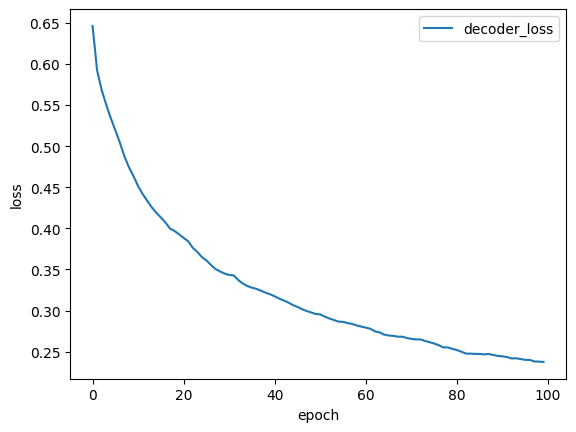

In [ ]:
plt.xlabel('epoch')
plt.ylabel('loss')
for i, row in enumerate(np.array(model.loss_history).T[3:]):
  plt.plot(row, label=f'decoder_loss')
plt.legend()

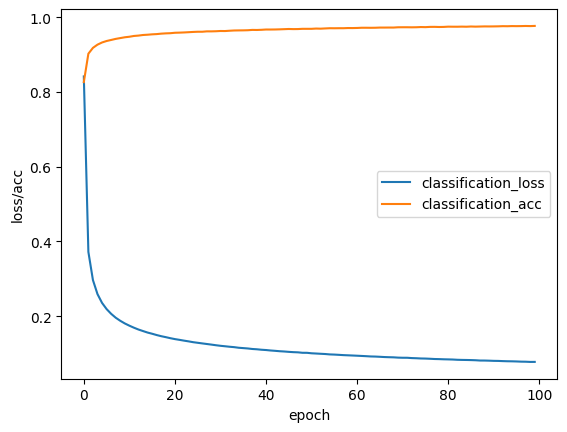

In [ ]:
plt.xlabel('epoch')
plt.ylabel('loss/acc')
plt.plot(model.classifier_loss_history, label=f'classification_loss')
plt.plot(model.classifier_acc_history, label=f'classification_acc')
plt.legend()

100%|██████████| 120/120 [00:01<00:00, 67.02it/s]


Acc: 0.9864166378974915
f1-score: 0.9862619004803344
[Reconstruction]


100%|██████████| 120/120 [00:03<00:00, 31.99it/s]


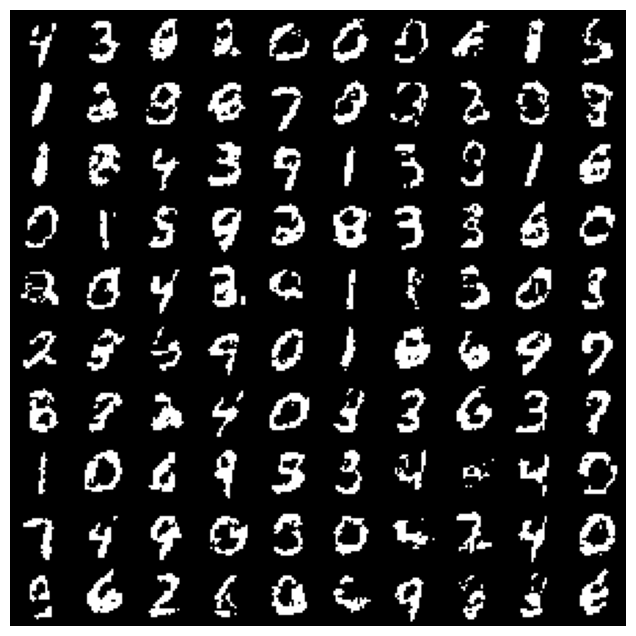

In [ ]:
test_set = MNIST('./data/', train=True, download=True)
x_test = test_set.data.type(torch.float32) / 255
x_test = to_binary(x_test, 0.5).unsqueeze(1)

preds = model.classifier(x_test)

# accuracy
acc = (preds.cpu() == test_set.targets).to(torch.float).mean().item()
print('Acc:', acc)

# f1-score
from sklearn.metrics import f1_score

f1_score = f1_score(test_set.targets, preds.cpu(), average='macro')
print('f1-score:', f1_score)

# reconstruct
dataset = FFDataset(x_test)
test_loader = DataLoader(dataset, batch_size=500, shuffle=False)

x_recon = model.reconstruct(test_loader)

display(x_recon)